# HPVD-M22 Function Walkthrough
## Menjelaskan Bagaimana Setiap Fungsi Bekerja

Notebook ini akan menjelaskan step-by-step bagaimana setiap fungsi di HPVD-M22 bekerja.

**Struktur:**
1. Setup & Imports
2. Trajectory Data Model
3. Synthetic Data Generator
4. Sparse Index (Regime-Based Filtering)
5. Dense Index (FAISS Vector Search)
6. Distance Calculator
7. HPVD Engine - Build Phase
8. HPVD Engine - Search Phase (Step by Step)
9. HPVD Engine - Full Search
10. End-to-End Example
11. 7 Stages Search Pipeline (Detail)
12. Admission Logic (Detail)
13. Family Formation Algorithm (Detail)
14. Summary & Key Takeaways

In [1]:
# Setup & Imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from typing import List, Dict, Set, Tuple

# Import HPVD components
from src.hpvd import (
    Trajectory, HPVDInputBundle,
    SyntheticDataGenerator,
    SparseRegimeIndex,
    DenseTrajectoryIndex, DenseIndexConfig,
    HybridDistanceCalculator, DistanceConfig,
    HPVDEngine, HPVDConfig,
    HPVD_Output, AnalogFamily
)

# Import FAISSIndexType enum
from src.hpvd.dense_index import FAISSIndexType

# Import sklearn for PCA
try:
    from sklearn.decomposition import PCA
    sklearn_available = True
except ImportError:
    print("⚠️ sklearn not available, PCA visualization will be skipped")
    sklearn_available = False

print("✅ All imports successful!")
print(f"HPVD Version: {__import__('src.hpvd').hpvd.__version__}")

✅ All imports successful!
HPVD Version: 1.0.0a1


## 1. Trajectory Data Model

Mari kita lihat bagaimana Trajectory dan HPVDInputBundle dibuat dan digunakan.

In [2]:
# Create a sample trajectory
sample_trajectory = Trajectory(
    trajectory_id="demo_traj_001",
    asset_id="AAPL",
    end_timestamp=datetime(2024, 1, 1, tzinfo=timezone.utc),
    matrix=np.random.randn(60, 45).astype(np.float32),
    embedding=np.random.randn(256).astype(np.float32),
    trend_regime=1,
    volatility_regime=0,
    structural_regime=1,
    asset_class="equity"
)

print("📊 Sample Trajectory:")
print(f"  ID: {sample_trajectory.trajectory_id}")
print(f"  Asset: {sample_trajectory.asset_id}")
print(f"  Matrix shape: {sample_trajectory.matrix.shape}")
print(f"  Embedding shape: {sample_trajectory.embedding.shape}")
print(f"  Regime: {sample_trajectory.get_regime_tuple()}")

# Convert to HPVDInputBundle
hpvd_bundle = sample_trajectory.to_hpvd_input(
    dna=np.random.randn(16).astype(np.float32),
    geometry_context={'LTV': 0.3, 'LVC': 0.1, 'K': 5.0},
    metadata={'scenario': 'demo', 'regime_id': 'R1'}
)

print("\n📦 HPVDInputBundle:")
print(f"  Trajectory shape: {hpvd_bundle.trajectory.shape}")
print(f"  DNA shape: {hpvd_bundle.dna.shape}")
print(f"  Geometry context: {hpvd_bundle.geometry_context}")
print(f"  Metadata: {hpvd_bundle.metadata}")

📊 Sample Trajectory:
  ID: demo_traj_001
  Asset: AAPL
  Matrix shape: (60, 45)
  Embedding shape: (256,)
  Regime: (1, 0, 1)

📦 HPVDInputBundle:
  Trajectory shape: (60, 45)
  DNA shape: (16,)
  Geometry context: {'LTV': 0.3, 'LVC': 0.1, 'K': 5.0}
  Metadata: {'scenario': 'demo', 'regime_id': 'R1'}


## 2. Synthetic Data Generator

Mari kita lihat bagaimana SyntheticDataGenerator membuat test data.

🔧 Generator created with seed=42 (deterministic)

📊 Scenario A Generated:
  Historical trajectories: 10
  Query trajectories: 1

📦 First Historical Bundle:
  Trajectory shape: (60, 45)
  DNA shape: (16,)
  Regime ID: R1
  Timestamp: 2020-01-01T00:00:00+00:00


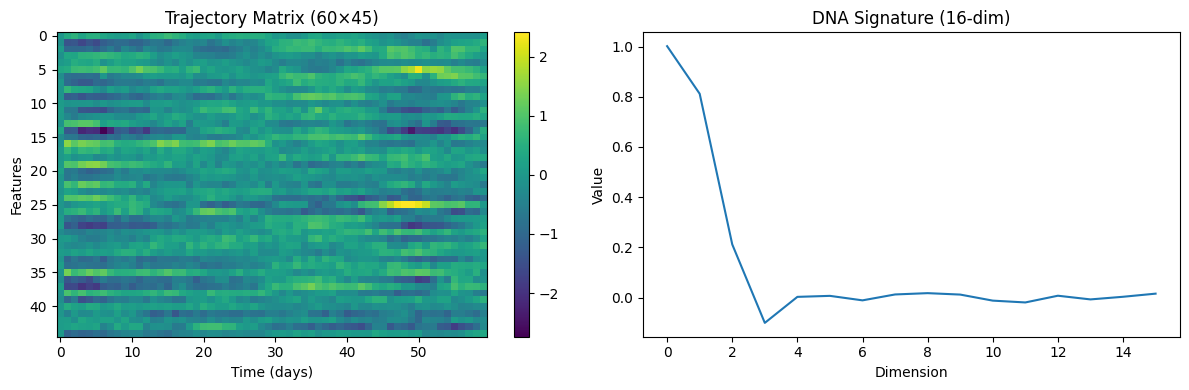

In [3]:
# Create generator
gen = SyntheticDataGenerator(seed=42)
print("🔧 Generator created with seed=42 (deterministic)")

# Generate Scenario A
data_a = gen.generate_scenario_a(n_historical=10, regime_id='R1')
print(f"\n📊 Scenario A Generated:")
print(f"  Historical trajectories: {len(data_a['historical'])}")
print(f"  Query trajectories: {len(data_a['query'])}")

# Inspect first historical bundle
hist_bundle = data_a['historical'][0]
print(f"\n📦 First Historical Bundle:")
print(f"  Trajectory shape: {hist_bundle.trajectory.shape}")
print(f"  DNA shape: {hist_bundle.dna.shape}")
print(f"  Regime ID: {hist_bundle.metadata.get('regime_id')}")
print(f"  Timestamp: {hist_bundle.metadata.get('timestamp')}")

# Visualize trajectory matrix
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(hist_bundle.trajectory.T, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Trajectory Matrix (60×45)')
plt.xlabel('Time (days)')
plt.ylabel('Features')

plt.subplot(1, 2, 2)
plt.plot(hist_bundle.dna)
plt.title('DNA Signature (16-dim)')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

## 3. Sparse Index (Regime-Based Filtering)


In [4]:
# Create sparse index
sparse_idx = SparseRegimeIndex()
print("🔍 Sparse Index created")

# Add some trajectories with different regimes
trajectories_to_add = [
    ("traj_001", 1, 0, 1, "AAPL", "equity"),   # UP trend, MED vol, TREND struct
    ("traj_002", 1, 0, 1, "AAPL", "equity"),   # Same regime
    ("traj_003", -1, 1, -1, "MSFT", "equity"), # DOWN trend, HIGH vol, REVERSE struct
    ("traj_004", 0, 0, 0, "GOOGL", "equity"),  # NEUTRAL everything
    ("traj_005", 1, 0, 1, "AAPL", "equity"),   # Same as traj_001
]

for traj_id, trend, vol, struct, asset, asset_class in trajectories_to_add:
    sparse_idx.add(traj_id, trend, vol, struct, asset, asset_class)

print(f"\n✅ Added {sparse_idx.total_count} trajectories")

# Query by regime - PERBAIKAN: gunakan filter_by_regime() bukan query_regime()
query_regime = (1, 0, 1)  # UP trend, MED vol, TREND struct
candidates = sparse_idx.filter_by_regime(
    trend=query_regime[0],
    volatility=query_regime[1],
    structural=query_regime[2],
    allow_adjacent=False  # Exact match only
)
print(f"\n🔍 Query regime {query_regime}:")
print(f"  Found {len(candidates)} candidates: {candidates}")

# Query by asset - PERBAIKAN: gunakan filter_by_asset() bukan query_asset()
candidates_by_asset = sparse_idx.filter_by_asset(["AAPL"])
print(f"\n🔍 Query asset 'AAPL':")
print(f"  Found {len(candidates_by_asset)} candidates: {candidates_by_asset}")

# Show index structure
print(f"\n📊 Index Statistics:")
print(f"  Unique regimes: {len(sparse_idx.regime_index)}")
print(f"  Unique assets: {len(sparse_idx.asset_index)}")
print(f"  Regime index structure:")
for regime, traj_ids in sparse_idx.regime_index.items():
    print(f"    {regime}: {traj_ids}")

🔍 Sparse Index created

✅ Added 5 trajectories

🔍 Query regime (1, 0, 1):
  Found 3 candidates: {'traj_005', 'traj_001', 'traj_002'}

🔍 Query asset 'AAPL':
  Found 3 candidates: {'traj_005', 'traj_001', 'traj_002'}

📊 Index Statistics:
  Unique regimes: 3
  Unique assets: 3
  Regime index structure:
    (1, 0, 1): {'traj_005', 'traj_001', 'traj_002'}
    (-1, 1, -1): {'traj_003'}
    (0, 0, 0): {'traj_004'}


## 4. Dense Index (FAISS Vector Search)


🔍 Dense Index created
Built flat_ip index: 100 vectors, 256 dims

✅ Built index with 100 vectors

🔍 Search for top 10 nearest neighbors:
  Query embedding shape: (256,)
  Query embedding norm: 1.0000

📊 Top 10 Results:
  1. traj_058 (distance: 0.8499)
  2. traj_031 (distance: 0.8761)
  3. traj_047 (distance: 0.8768)
  4. traj_091 (distance: 0.8894)
  5. traj_064 (distance: 0.8901)
  6. traj_017 (distance: 0.8951)
  7. traj_074 (distance: 0.9013)
  8. traj_030 (distance: 0.9072)
  9. traj_069 (distance: 0.9173)
  10. traj_094 (distance: 0.9244)


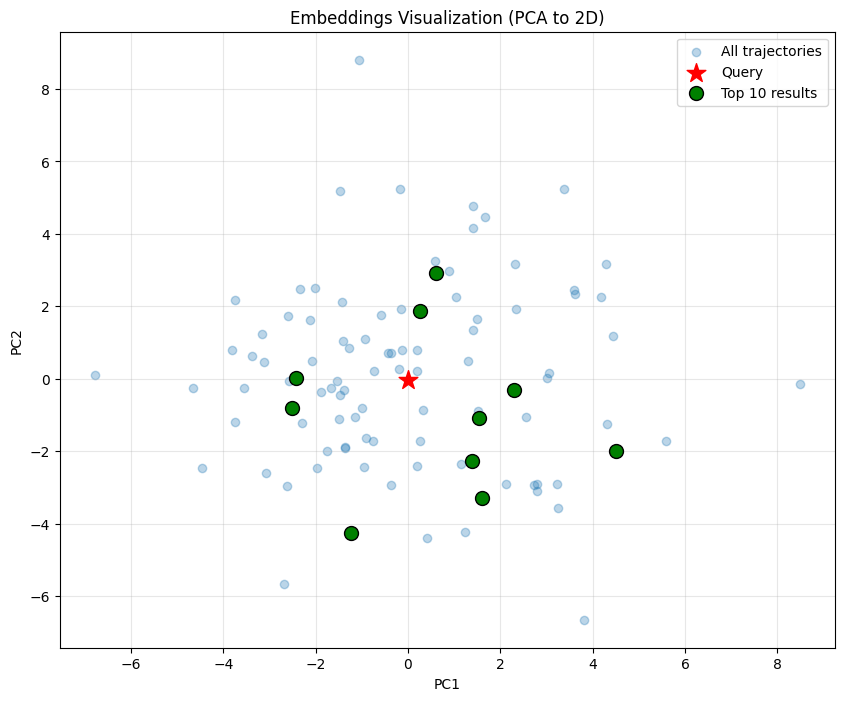

In [5]:
# Create dense index
config = DenseIndexConfig(
    dimension=256,
    index_type=FAISSIndexType.FLAT_IP,  # Exact inner product
    use_cosine=True  # Normalize for cosine similarity
)
dense_idx = DenseTrajectoryIndex(config)
print("🔍 Dense Index created")

# Generate sample embeddings
n_trajectories = 100
embeddings = np.random.randn(n_trajectories, 256).astype(np.float32)
trajectory_ids = [f"traj_{i:03d}" for i in range(n_trajectories)]

# Build index
dense_idx.build(embeddings, trajectory_ids)
print(f"\n✅ Built index with {dense_idx.ntotal} vectors")

# Create query embedding
query_embedding = np.random.randn(256).astype(np.float32)
query_embedding = query_embedding / np.linalg.norm(query_embedding)  # Normalize

# Search
k = 10
results = dense_idx.search(query_embedding, k=k)
print(f"\n🔍 Search for top {k} nearest neighbors:")
print(f"  Query embedding shape: {query_embedding.shape}")
print(f"  Query embedding norm: {np.linalg.norm(query_embedding):.4f}")

print(f"\n📊 Top {k} Results:")
for i, (traj_id, dist) in enumerate(results, 1):
    print(f"  {i}. {traj_id} (distance: {dist:.4f})")

# Visualize embeddings (PCA to 2D)
if sklearn_available:
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    query_2d = pca.transform(query_embedding.reshape(1, -1))

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.3, label='All trajectories')
    plt.scatter(query_2d[0, 0], query_2d[0, 1], c='red', s=200, marker='*', label='Query', zorder=5)

    # Highlight top k results
    # Get indices for top k results
    top_k_indices = [dense_idx.id_to_idx[traj_id] for traj_id, _ in results[:k]]
    top_k_2d = embeddings_2d[top_k_indices]
    plt.scatter(top_k_2d[:, 0], top_k_2d[:, 1], c='green', s=100, marker='o', 
                label=f'Top {k} results', zorder=4, edgecolors='black', linewidths=1)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Embeddings Visualization (PCA to 2D)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("\n⚠️ Skipping PCA visualization (sklearn not available)")

## 5. Hybrid Distance Calculator



📏 Distance Calculator created

📊 Distance Calculation:
  Trajectory 1: traj_001 (regime: (1, 0, 1))
  Trajectory 2: traj_002 (regime: (1, 0, 1))
  Total distance: 0.0308

📏 Component Breakdown:
  Euclidean (raw): 5.2283
  Euclidean (normalized): 0.0503 (weight: 0.3)
  Cosine (raw): 0.0051
  Cosine (normalized): 0.0025 (weight: 0.4)
  Temporal (raw): 0.6585
  Temporal (normalized): 0.0491 (weight: 0.3)
  Regime match score: 1.0000
  Regime penalty: 0.0000
  Base distance: 0.0308
  Final distance: 0.0308


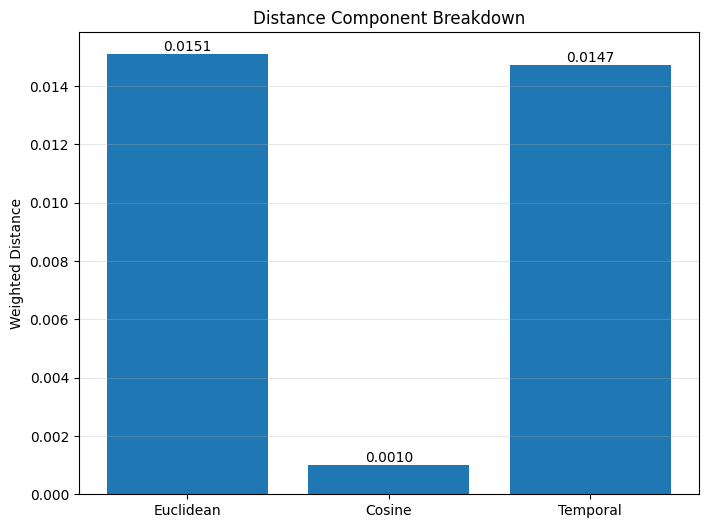

In [6]:
# Create distance calculator
dist_config = DistanceConfig(
    weight_euclidean=0.3,
    weight_cosine=0.4,
    weight_temporal=0.3,
    regime_penalty_weight=0.2
)
dist_calc = HybridDistanceCalculator(dist_config)
print("📏 Distance Calculator created")

# Create two trajectories
traj1 = Trajectory(
    trajectory_id="traj_001",
    asset_id="AAPL",
    end_timestamp=datetime(2024, 1, 1, tzinfo=timezone.utc),
    matrix=np.random.randn(60, 45).astype(np.float32),
    embedding=np.random.randn(256).astype(np.float32),
    trend_regime=1,
    volatility_regime=0,
    structural_regime=1
)

traj2 = Trajectory(
    trajectory_id="traj_002",
    asset_id="AAPL",
    end_timestamp=datetime(2024, 1, 5, tzinfo=timezone.utc),  # 4 days later
    matrix=traj1.matrix + np.random.randn(60, 45).astype(np.float32) * 0.1,  # Similar but noisy
    embedding=traj1.embedding + np.random.randn(256).astype(np.float32) * 0.1,
    trend_regime=1,  # Same regime
    volatility_regime=0,
    structural_regime=1
)

# Compute distance using compute() method
distance, components_dict = dist_calc.compute(
    traj1.matrix,
    traj2.matrix,
    traj1.get_regime_tuple(),
    traj2.get_regime_tuple()
)
print(f"\n📊 Distance Calculation:")
print(f"  Trajectory 1: {traj1.trajectory_id} (regime: {traj1.get_regime_tuple()})")
print(f"  Trajectory 2: {traj2.trajectory_id} (regime: {traj2.get_regime_tuple()})")
print(f"  Total distance: {distance:.4f}")

# Break down components from components_dict
print(f"\n📏 Component Breakdown:")
print(f"  Euclidean (raw): {components_dict['euclidean_raw']:.4f}")
print(f"  Euclidean (normalized): {components_dict['euclidean_norm']:.4f} (weight: {dist_config.weight_euclidean})")
print(f"  Cosine (raw): {components_dict['cosine_raw']:.4f}")
print(f"  Cosine (normalized): {components_dict['cosine_norm']:.4f} (weight: {dist_config.weight_cosine})")
print(f"  Temporal (raw): {components_dict['temporal_raw']:.4f}")
print(f"  Temporal (normalized): {components_dict['temporal_norm']:.4f} (weight: {dist_config.weight_temporal})")
print(f"  Regime match score: {components_dict['regime_match']:.4f}")
print(f"  Regime penalty: {components_dict['regime_penalty']:.4f}")
print(f"  Base distance: {components_dict['base_distance']:.4f}")
print(f"  Final distance: {distance:.4f}")

# Visualize distance components
components = {
    'Euclidean': components_dict['euclidean_norm'] * dist_config.weight_euclidean,
    'Cosine': components_dict['cosine_norm'] * dist_config.weight_cosine,
    'Temporal': components_dict['temporal_norm'] * dist_config.weight_temporal
}

plt.figure(figsize=(8, 6))
plt.bar(components.keys(), components.values())
plt.ylabel('Weighted Distance')
plt.title('Distance Component Breakdown')
plt.grid(True, alpha=0.3, axis='y')
for i, (k, v) in enumerate(components.items()):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.show()

## 6. HPVD Engine - Build Phase



In [7]:
# Create engine
config = HPVDConfig(
    default_k=25,
    enable_sparse_filter=True,
    enable_reranking=True
)
engine = HPVDEngine(config)
print("🚀 HPVD Engine created")

# Generate data
gen = SyntheticDataGenerator(seed=42)
data = gen.generate_scenario_a(n_historical=50, regime_id='R1')

# Build from bundles
print("\n🔨 Building HPVD Engine...")
engine.build_from_bundles(data['historical'])
print("✅ Build complete!")

# Show statistics
stats = engine.get_statistics()
print(f"\n📊 Build Statistics:")
print(f"  Total trajectories: {stats['total_trajectories']}")
print(f"  Sparse index regimes: {stats['sparse_index_stats']['unique_regimes']}")
print(f"  Dense index vectors: {stats['dense_index_vectors']}")
print(f"  Is built: {engine.is_built}")

# Inspect sparse index
print(f"\n🔍 Sparse Index Details:")
print(f"  Total trajectories in sparse index: {engine.sparse_index.total_count}")
print(f"  Unique regime combinations: {len(engine.sparse_index.regime_index)}")
for regime, traj_ids in list(engine.sparse_index.regime_index.items())[:3]:
    print(f"    {regime}: {len(traj_ids)} trajectories")

# Inspect dense index
print(f"\n🔍 Dense Index Details:")
print(f"  Total vectors: {engine.dense_index.ntotal}")
print(f"  Dimension: {engine.dense_index.config.dimension}")
print(f"  Index type: {engine.dense_index.config.index_type}")

🚀 HPVD Engine created

🔨 Building HPVD Engine...
Building HPVD with 50 trajectories...
Built flat_ip index: 50 vectors, 256 dims
HPVD built in 0.00s
  Sparse index: 1 regimes
  Dense index: 50 vectors
✅ Build complete!

📊 Build Statistics:
  Total trajectories: 50
  Sparse index regimes: 1
  Dense index vectors: 50
  Is built: True

🔍 Sparse Index Details:
  Total trajectories in sparse index: 50
  Unique regime combinations: 1
    (1, 0, 1): 50 trajectories

🔍 Dense Index Details:
  Total vectors: 50
  Dimension: 256
  Index type: FAISSIndexType.FLAT_IP


## 7. HPVD Engine - Search Phase (Step by Step)

Mari kita trace bagaimana search bekerja step-by-step.

In [8]:
# Use query from generated data
query_bundle = data['query'][0]
print("🔍 Query Bundle:")
print(f"  Trajectory shape: {query_bundle.trajectory.shape}")
print(f"  DNA shape: {query_bundle.dna.shape}")
print(f"  Regime ID: {query_bundle.metadata.get('regime_id')}")

# Convert to trajectory (internal)
query_traj = engine._bundle_to_trajectory(query_bundle)
print(f"\n📊 Query Trajectory:")
print(f"  ID: {query_traj.trajectory_id}")
print(f"  Regime: {query_traj.get_regime_tuple()}")

# Step 1: Sparse Filter - PERBAIKAN: gunakan filter_by_regime()
print("\n" + "="*70)
print("STEP 1: SPARSE FILTER")
print("="*70)
sparse_candidates = engine.sparse_index.filter_by_regime(
    trend=query_traj.trend_regime,
    volatility=query_traj.volatility_regime,
    structural=query_traj.structural_regime,
    allow_adjacent=False  # Exact match
)
print(f"  Query regime: {query_traj.get_regime_tuple()}")
print(f"  Candidates found: {len(sparse_candidates)}")
print(f"  Sample candidates: {list(sparse_candidates)[:5]}")

# Step 2: Dense Search
print("\n" + "="*70)
print("STEP 2: DENSE SEARCH")
print("="*70)
search_k = min(75, len(sparse_candidates) * 3)
dense_results = engine.dense_index.search(query_traj.embedding, k=search_k)
print(f"  Search k: {search_k}")
print(f"  Results returned: {len(dense_results)}")
print(f"  Top 5 distances: {[dist for _, dist in dense_results[:5]]}")

# dense_results is already List[Tuple[traj_id, distance]]
print(f"  Top 5 trajectory IDs: {[t[0] for t in dense_results[:5]]}")

# Step 3: Intersection
print("\n" + "="*70)
print("STEP 3: INTERSECTION")
print("="*70)
intersected = [(tid, dist) for tid, dist in dense_results if tid in sparse_candidates]
print(f"  Dense results: {len(dense_results)}")
print(f"  Sparse candidates: {len(sparse_candidates)}")
print(f"  Intersected: {len(intersected)}")
print(f"  Sample intersected: {[t[0] for t in intersected[:5]]}")

# Step 4: Rerank
print("\n" + "="*70)
print("STEP 4: RERANK (Hybrid Distance)")
print("="*70)
reranked = []
for traj_id, _ in intersected[:50]:  # Top 50 for reranking
    candidate = engine.trajectories[traj_id]
    distance, _ = engine.distance_calc.compute(
        query_traj.matrix,
        candidate.matrix,
        query_traj.get_regime_tuple(),
        candidate.get_regime_tuple()
    )
    reranked.append((traj_id, distance))

reranked.sort(key=lambda x: x[1])  # Sort by distance
print(f"  Reranked {len(reranked)} candidates")
print(f"  Top 5 after reranking:")
for i, (tid, dist) in enumerate(reranked[:5], 1):
    print(f"    {i}. {tid}: {dist:.4f}")

# Step 5: Group into Families
print("\n" + "="*70)
print("STEP 5: GROUP INTO FAMILIES")
print("="*70)
# This is simplified - actual implementation is more complex
print(f"  Top {config.default_k} candidates will be grouped into families")
print(f"  Family grouping considers structural similarity and coherence")

🔍 Query Bundle:
  Trajectory shape: (60, 45)
  DNA shape: (16,)
  Regime ID: R1

📊 Query Trajectory:
  ID: scenario_A_query_001
  Regime: (1, 0, 1)

STEP 1: SPARSE FILTER
  Query regime: (1, 0, 1)
  Candidates found: 50
  Sample candidates: ['scenario_A_hist_045', 'scenario_A_hist_025', 'scenario_A_hist_044', 'scenario_A_hist_021', 'scenario_A_hist_037']

STEP 2: DENSE SEARCH
  Search k: 75
  Results returned: 50
  Top 5 distances: [0.6950121521949768, 0.7665271013975143, 0.7733302116394043, 0.7825695872306824, 0.7954250425100327]
  Top 5 trajectory IDs: ['scenario_A_hist_016', 'scenario_A_hist_015', 'scenario_A_hist_002', 'scenario_A_hist_031', 'scenario_A_hist_026']

STEP 3: INTERSECTION
  Dense results: 50
  Sparse candidates: 50
  Intersected: 50
  Sample intersected: ['scenario_A_hist_016', 'scenario_A_hist_015', 'scenario_A_hist_002', 'scenario_A_hist_031', 'scenario_A_hist_026']

STEP 4: RERANK (Hybrid Distance)
  Reranked 50 candidates
  Top 5 after reranking:
    1. scenario_A

## 8. HPVD Engine - Full Search (Complete)

Sekarang mari kita jalankan search lengkap dan lihat hasilnya.

🔍 Running full search...

SEARCH RESULTS
  Families formed: 1
  Candidates considered: 50
  Candidates retrieved: 50
  Candidates admitted: 50
  Latency: 2.00ms

📊 Analog Families:

  Family 1: AF_001
    Phase: stable_expansion
    Members: 50
    Mean Confidence: 0.5505
    Dispersion: 0.0318
    Top 3 Members:
      1. scenario_A_hist_043 (confidence: 0.6127)
      2. scenario_A_hist_016 (confidence: 0.6075)
      3. scenario_A_hist_031 (confidence: 0.6070)


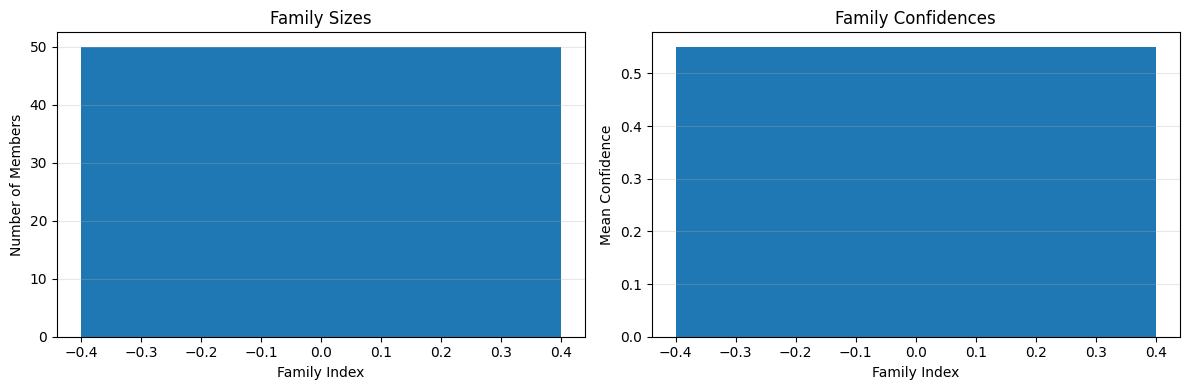

In [9]:
# Run full search
print("🔍 Running full search...")
output = engine.search_families(query_bundle, max_candidates=100)

print("\n" + "="*70)
print("SEARCH RESULTS")
print("="*70)
print(f"  Families formed: {len(output.analog_families)}")
print(f"  Candidates considered: {output.retrieval_diagnostics['candidates_considered']}")
print(f"  Candidates retrieved: {output.retrieval_diagnostics['candidates_retrieved']}")
print(f"  Candidates admitted: {output.retrieval_diagnostics['candidates_admitted']}")
print(f"  Latency: {output.retrieval_diagnostics['latency_ms']:.2f}ms")

print(f"\n📊 Analog Families:")
for i, family in enumerate(output.analog_families[:5], 1):
    print(f"\n  Family {i}: {family.family_id}")
    print(f"    Phase: {family.structural_signature.phase}")
    print(f"    Members: {family.coherence.size}")
    print(f"    Mean Confidence: {family.coherence.mean_confidence:.4f}")
    print(f"    Dispersion: {family.coherence.dispersion:.4f}")
    print(f"    Top 3 Members:")
    for j, member in enumerate(family.members[:3], 1):
        print(f"      {j}. {member.trajectory_id} (confidence: {member.confidence:.4f})")

# Visualize family structure
if len(output.analog_families) > 0:
    family_sizes = [f.coherence.size for f in output.analog_families]
    family_confidences = [f.coherence.mean_confidence for f in output.analog_families]
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(family_sizes)), family_sizes)
    plt.xlabel('Family Index')
    plt.ylabel('Number of Members')
    plt.title('Family Sizes')
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.subplot(1, 2, 2)
    plt.bar(range(len(family_confidences)), family_confidences)
    plt.xlabel('Family Index')
    plt.ylabel('Mean Confidence')
    plt.title('Family Confidences')
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 9. End-to-End Example



## 10. 7 Stages Search Pipeline (Detail)

Mari kita trace secara detail semua 7 stages dalam `search_families()` sesuai implementasi engine yang sebenarnya.

In [10]:
# Setup: Create engine and build index
gen = SyntheticDataGenerator(seed=42)
data = gen.generate_scenario_a(n_historical=100, regime_id='R1')
engine = HPVDEngine(HPVDConfig(default_k=25, enable_sparse_filter=True, enable_reranking=True))
engine.build_from_bundles(data['historical'])

query_bundle = data['query'][0]
query_traj = engine._bundle_to_trajectory(query_bundle)
query_regime = query_traj.get_regime_tuple()

print("="*70)
print("7 STAGES SEARCH PIPELINE - DETAILED TRACE")
print("="*70)
print(f"\nQuery Trajectory:")
print(f"  ID: {query_traj.trajectory_id}")
print(f"  Regime: {query_regime}")
print(f"  Total trajectories in index: {len(engine.trajectories)}")

import time
latency = {}
total_start = time.time()

# ========== STAGE 1: Evolutionary Compatibility Screening ==========
print("\n" + "="*70)
print("STAGE 1: Evolutionary Compatibility Screening (Sparse Filter)")
print("="*70)
stage_start = time.time()

# Step 1.1: Initial filter dengan semua regime constraints
candidate_ids = engine.sparse_index.combined_filter(
    trend=query_traj.trend_regime,
    volatility=query_traj.volatility_regime,
    structural=query_traj.structural_regime,
    allow_adjacent=True  # Allow adjacent regimes (±1)
)
print(f"  Initial filter (all regimes): {len(candidate_ids)} candidates")

# Step 1.2: Fallback jika terlalu sedikit candidates
if len(candidate_ids) < engine.config.min_candidates:
    print(f"  ⚠️ Too few candidates ({len(candidate_ids)} < {engine.config.min_candidates})")
    print(f"  → Fallback: Filter hanya berdasarkan trend regime")
    candidate_ids = engine.sparse_index.combined_filter(
        trend=query_traj.trend_regime,
        allow_adjacent=True
    )
    print(f"  After fallback: {len(candidate_ids)} candidates")

# Step 1.3: Final fallback jika masih terlalu sedikit
if len(candidate_ids) < 10:
    print(f"  ⚠️ Still too few ({len(candidate_ids)} < 10)")
    print(f"  → Final fallback: Use ALL trajectories")
    candidate_ids = set(engine.trajectories.keys())
    print(f"  After final fallback: {len(candidate_ids)} candidates")

candidates_after_screening = len(candidate_ids)
latency['screening_ms'] = (time.time() - stage_start) * 1000
print(f"\n  ✅ Stage 1 Complete: {candidates_after_screening} candidates after screening")
print(f"  ⏱️  Latency: {latency['screening_ms']:.2f}ms")

# ========== STAGE 2: Candidate Retrieval ==========
print("\n" + "="*70)
print("STAGE 2: Candidate Retrieval (Dense Search with Filter)")
print("="*70)
stage_start = time.time()

max_candidates = engine.config.default_k * 5  # 25 * 5 = 125
search_k = min(max_candidates, len(candidate_ids))
print(f"  Search k: {search_k} (max_candidates={max_candidates}, available={len(candidate_ids)})")

# Use search_with_filter (bukan search biasa!)
dense_results = engine.dense_index.search_with_filter(
    query_embedding=query_traj.embedding,
    candidate_ids=candidate_ids,
    k=search_k
)

candidates_retrieved = len(dense_results)
latency['retrieval_ms'] = (time.time() - stage_start) * 1000
print(f"\n  ✅ Stage 2 Complete: {candidates_retrieved} candidates retrieved")
print(f"  ⏱️  Latency: {latency['retrieval_ms']:.2f}ms")
print(f"  Top 5 FAISS distances: {[dist for _, dist in dense_results[:5]]}")

# ========== STAGE 3: Multi-Channel Similarity Evaluation ==========
print("\n" + "="*70)
print("STAGE 3: Multi-Channel Similarity Evaluation")
print("="*70)
stage_start = time.time()

evaluated_candidates = []

for tid, faiss_dist in dense_results:
    traj = engine.trajectories.get(tid)
    if traj is None:
        continue
    
    # Compute hybrid distance
    hybrid_dist, components = engine.distance_calc.compute(
        query_traj.matrix,
        traj.matrix,
        query_regime,
        traj.get_regime_tuple()
    )
    
    # Confidence = inverse of normalized distance
    confidence = max(0.0, 1.0 - min(hybrid_dist, 1.0))
    
    evaluated_candidates.append({
        'trajectory_id': tid,
        'trajectory': traj,
        'confidence': confidence,
        'hybrid_distance': hybrid_dist,
        'regime_match': components['regime_match'],
        'distance_components': components,
        'regime_tuple': traj.get_regime_tuple()
    })

latency['evaluation_ms'] = (time.time() - stage_start) * 1000
print(f"\n  ✅ Stage 3 Complete: {len(evaluated_candidates)} candidates evaluated")
print(f"  ⏱️  Latency: {latency['evaluation_ms']:.2f}ms")
print(f"  Confidence range: [{min(c['confidence'] for c in evaluated_candidates):.3f}, {max(c['confidence'] for c in evaluated_candidates):.3f}]")
print(f"  Average confidence: {np.mean([c['confidence'] for c in evaluated_candidates]):.3f}")

# ========== STAGE 4: Probabilistic Neighborhood Admission ==========
print("\n" + "="*70)
print("STAGE 4: Probabilistic Neighborhood Admission")
print("="*70)
stage_start = time.time()

admission_threshold = 0.3  # Minimum confidence to be admitted
print(f"  Admission threshold: {admission_threshold}")

admitted = [
    c for c in evaluated_candidates
    if c['confidence'] >= admission_threshold
]
rejected = [
    c for c in evaluated_candidates
    if c['confidence'] < admission_threshold
]

latency['admission_ms'] = (time.time() - stage_start) * 1000
print(f"\n  ✅ Stage 4 Complete:")
print(f"    Admitted: {len(admitted)} candidates")
print(f"    Rejected: {len(rejected)} candidates")
print(f"  ⏱️  Latency: {latency['admission_ms']:.2f}ms")

if len(rejected) > 0:
    print(f"\n  Rejected candidates (confidence < {admission_threshold}):")
    for c in rejected[:5]:
        print(f"    {c['trajectory_id']}: confidence={c['confidence']:.3f}")

# ========== STAGE 5: Analog Family Formation ==========
print("\n" + "="*70)
print("STAGE 5: Analog Family Formation")
print("="*70)
stage_start = time.time()

families = engine._form_analog_families(admitted, query_regime)

latency['family_formation_ms'] = (time.time() - stage_start) * 1000
print(f"\n  ✅ Stage 5 Complete: {len(families)} families formed")
print(f"  ⏱️  Latency: {latency['family_formation_ms']:.2f}ms")

# ========== STAGE 6: Uncertainty Annotation ==========
print("\n" + "="*70)
print("STAGE 6: Uncertainty Annotation")
print("="*70)
print("  (Computed during family formation)")
print(f"  Families with uncertainty flags:")
for i, family in enumerate(families[:3], 1):
    flags = family.uncertainty_flags
    print(f"    Family {i}: phase_boundary={flags.phase_boundary}, "
          f"weak_support={flags.weak_support}, "
          f"partial_overlap={flags.partial_overlap}")

# ========== STAGE 7: Output Assembly ==========
print("\n" + "="*70)
print("STAGE 7: Output Assembly")
print("="*70)
latency['total_ms'] = (time.time() - total_start) * 1000

diagnostics = {
    'candidates_considered': candidates_after_screening,
    'candidates_retrieved': candidates_retrieved,
    'candidates_admitted': len(admitted),
    'candidates_rejected': len(rejected),
    'families_formed': len(families),
    'latency_ms': latency['total_ms']
}

metadata = {
    'hpvd_version': 'v1',
    'query_id': query_bundle.metadata.get('trajectory_id', query_traj.trajectory_id),
    'schema_version': 'hpvd_output_v1',
    'timestamp': query_bundle.metadata.get('timestamp', '')
}

output = HPVD_Output(
    analog_families=families,
    retrieval_diagnostics=diagnostics,
    metadata=metadata
)

print(f"\n  ✅ Stage 7 Complete: HPVD_Output assembled")
print(f"\n  📊 Final Diagnostics:")
for key, value in diagnostics.items():
    print(f"    {key}: {value}")

print(f"\n  ⏱️  Total Latency: {latency['total_ms']:.2f}ms")
print(f"    Breakdown:")
print(f"      Stage 1 (Screening): {latency['screening_ms']:.2f}ms")
print(f"      Stage 2 (Retrieval): {latency['retrieval_ms']:.2f}ms")
print(f"      Stage 3 (Evaluation): {latency['evaluation_ms']:.2f}ms")
print(f"      Stage 4 (Admission): {latency['admission_ms']:.2f}ms")
print(f"      Stage 5 (Family Formation): {latency['family_formation_ms']:.2f}ms")

print("\n" + "="*70)
print("✅ 7 STAGES PIPELINE COMPLETE")
print("="*70)

Building HPVD with 100 trajectories...
Built flat_ip index: 100 vectors, 256 dims
HPVD built in 0.00s
  Sparse index: 1 regimes
  Dense index: 100 vectors
7 STAGES SEARCH PIPELINE - DETAILED TRACE

Query Trajectory:
  ID: scenario_A_query_001
  Regime: (1, 0, 1)
  Total trajectories in index: 100

STAGE 1: Evolutionary Compatibility Screening (Sparse Filter)
  Initial filter (all regimes): 100 candidates

  ✅ Stage 1 Complete: 100 candidates after screening
  ⏱️  Latency: 0.00ms

STAGE 2: Candidate Retrieval (Dense Search with Filter)
  Search k: 100 (max_candidates=125, available=100)

  ✅ Stage 2 Complete: 100 candidates retrieved
  ⏱️  Latency: 0.00ms
  Top 5 FAISS distances: [0.6747905611991882, 0.7204331159591675, 0.7644719332456589, 0.7650613039731979, 0.783513069152832]

STAGE 3: Multi-Channel Similarity Evaluation

  ✅ Stage 3 Complete: 100 candidates evaluated
  ⏱️  Latency: 3.00ms
  Confidence range: [0.424, 0.569]
  Average confidence: 0.507

STAGE 4: Probabilistic Neighborh

## 11. Admission Logic (Detail)



Building HPVD with 100 trajectories...
Built flat_ip index: 100 vectors, 256 dims
HPVD built in 0.00s
  Sparse index: 1 regimes
  Dense index: 100 vectors
ADMISSION LOGIC ANALYSIS

📊 Confidence Distribution:
  Total candidates evaluated: 100
  Min confidence: 0.4244
  Max confidence: 0.5689
  Mean confidence: 0.5074
  Median confidence: 0.5169
  Std deviation: 0.0329

🔍 Admission Results for Different Thresholds:
Threshold    Admitted     Rejected     Admission Rate 
------------------------------------------------------------
0.1          100          0            100.0          %
0.2          100          0            100.0          %
0.3          100          0            100.0          %
0.4          100          0            100.0          %
0.5          64           36           64.0           %
0.6          0            100          0.0            %
0.7          0            100          0.0            %

📋 Default Threshold (0.3) Analysis:
  Admitted: 100 candidates
  Rejected:

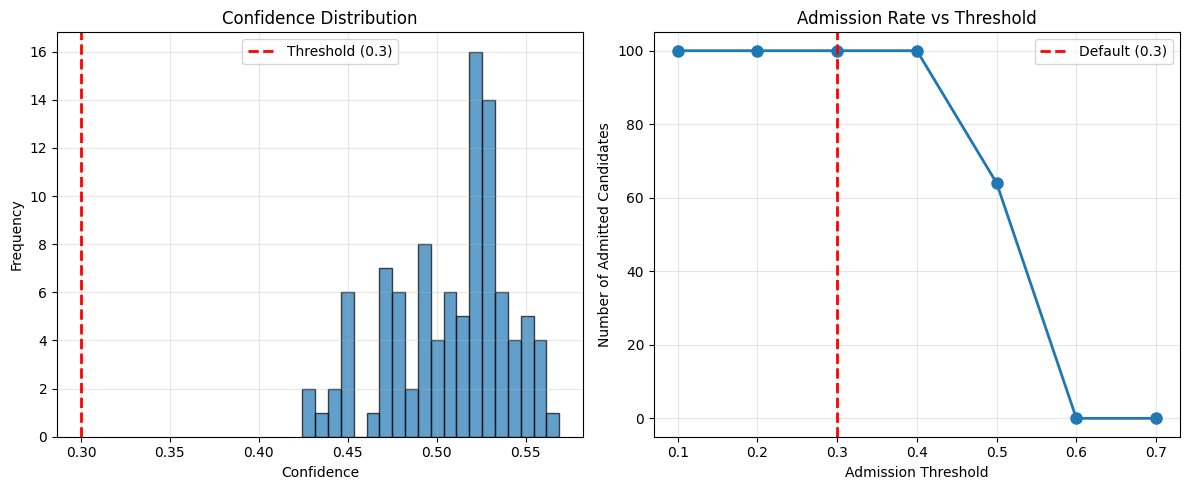


✅ ADMISSION LOGIC ANALYSIS COMPLETE


In [11]:
# Setup
gen = SyntheticDataGenerator(seed=42)
data = gen.generate_scenario_a(n_historical=100, regime_id='R1')
engine = HPVDEngine(HPVDConfig(default_k=25))
engine.build_from_bundles(data['historical'])

query_bundle = data['query'][0]
query_traj = engine._bundle_to_trajectory(query_bundle)

# Run search untuk mendapatkan evaluated candidates
candidate_ids = engine.sparse_index.combined_filter(
    trend=query_traj.trend_regime,
    volatility=query_traj.volatility_regime,
    structural=query_traj.structural_regime,
    allow_adjacent=True
)
dense_results = engine.dense_index.search_with_filter(
    query_traj.embedding, candidate_ids, k=100
)

query_regime = query_traj.get_regime_tuple()
evaluated_candidates = []

for tid, faiss_dist in dense_results:
    traj = engine.trajectories.get(tid)
    if traj is None:
        continue
    
    hybrid_dist, components = engine.distance_calc.compute(
        query_traj.matrix, traj.matrix,
        query_regime, traj.get_regime_tuple()
    )
    confidence = max(0.0, 1.0 - min(hybrid_dist, 1.0))
    
    evaluated_candidates.append({
        'trajectory_id': tid,
        'confidence': confidence,
        'hybrid_distance': hybrid_dist,
        'regime_match': components['regime_match']
    })

print("="*70)
print("ADMISSION LOGIC ANALYSIS")
print("="*70)

# Analyze confidence distribution
confidences = [c['confidence'] for c in evaluated_candidates]
print(f"\n📊 Confidence Distribution:")
print(f"  Total candidates evaluated: {len(evaluated_candidates)}")
print(f"  Min confidence: {min(confidences):.4f}")
print(f"  Max confidence: {max(confidences):.4f}")
print(f"  Mean confidence: {np.mean(confidences):.4f}")
print(f"  Median confidence: {np.median(confidences):.4f}")
print(f"  Std deviation: {np.std(confidences):.4f}")

# Test different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
print(f"\n🔍 Admission Results for Different Thresholds:")
print(f"{'Threshold':<12} {'Admitted':<12} {'Rejected':<12} {'Admission Rate':<15}")
print("-" * 60)

for threshold in thresholds:
    admitted = [c for c in evaluated_candidates if c['confidence'] >= threshold]
    rejected = [c for c in evaluated_candidates if c['confidence'] < threshold]
    admission_rate = len(admitted) / len(evaluated_candidates) * 100
    print(f"{threshold:<12.1f} {len(admitted):<12} {len(rejected):<12} {admission_rate:<15.1f}%")

# Default threshold analysis
default_threshold = 0.3
admitted_default = [c for c in evaluated_candidates if c['confidence'] >= default_threshold]
rejected_default = [c for c in evaluated_candidates if c['confidence'] < default_threshold]

print(f"\n📋 Default Threshold ({default_threshold}) Analysis:")
print(f"  Admitted: {len(admitted_default)} candidates")
print(f"  Rejected: {len(rejected_default)} candidates")
print(f"  Admission rate: {len(admitted_default)/len(evaluated_candidates)*100:.1f}%")

print(f"\n  Admitted candidates (top 10 by confidence):")
for i, c in enumerate(sorted(admitted_default, key=lambda x: x['confidence'], reverse=True)[:10], 1):
    print(f"    {i}. {c['trajectory_id']}: confidence={c['confidence']:.4f}, "
          f"distance={c['hybrid_distance']:.4f}, regime_match={c['regime_match']:.2f}")

print(f"\n  Rejected candidates (lowest confidence):")
for i, c in enumerate(sorted(rejected_default, key=lambda x: x['confidence'])[:5], 1):
    print(f"    {i}. {c['trajectory_id']}: confidence={c['confidence']:.4f}, "
          f"distance={c['hybrid_distance']:.4f}, regime_match={c['regime_match']:.2f}")

# Visualize confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(confidences, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(default_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({default_threshold})')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
admission_counts = [len([c for c in evaluated_candidates if c['confidence'] >= t]) 
                    for t in thresholds]
plt.plot(thresholds, admission_counts, marker='o', linewidth=2, markersize=8)
plt.axvline(default_threshold, color='red', linestyle='--', linewidth=2, label=f'Default ({default_threshold})')
plt.xlabel('Admission Threshold')
plt.ylabel('Number of Admitted Candidates')
plt.title('Admission Rate vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✅ ADMISSION LOGIC ANALYSIS COMPLETE")
print("="*70)

## 12. Family Formation Algorithm (Detail)

Mari kita lihat bagaimana analog families dibentuk dari admitted candidates.

Building HPVD with 100 trajectories...
Built flat_ip index: 100 vectors, 256 dims
HPVD built in 0.00s
  Sparse index: 1 regimes
  Dense index: 100 vectors
FAMILY FORMATION ALGORITHM - DETAILED TRACE

📊 Input:
  Admitted candidates: 100
  Query regime: (1, 0, 1)

STEP 1: Group by Regime Tuple
  Unique regimes found: 1
    (1, 0, 1): 100 members

STEP 2: Form Families (One per Regime Group)

  Family AF_001:
    Regime: (1, 0, 1)
    Phase: stable_expansion
    Members: 100
    Mean confidence: 0.5074
    Dispersion: 0.0329
    Uncertainty flags:
      phase_boundary: False
      weak_support: False
    Top 3 members:
      1. scenario_A_hist_034: confidence=0.5689
      2. scenario_A_hist_071: confidence=0.5610
      3. scenario_A_hist_049: confidence=0.5557

FAMILY FORMATION SUMMARY
  Total families formed: 1
  Total members across all families: 100


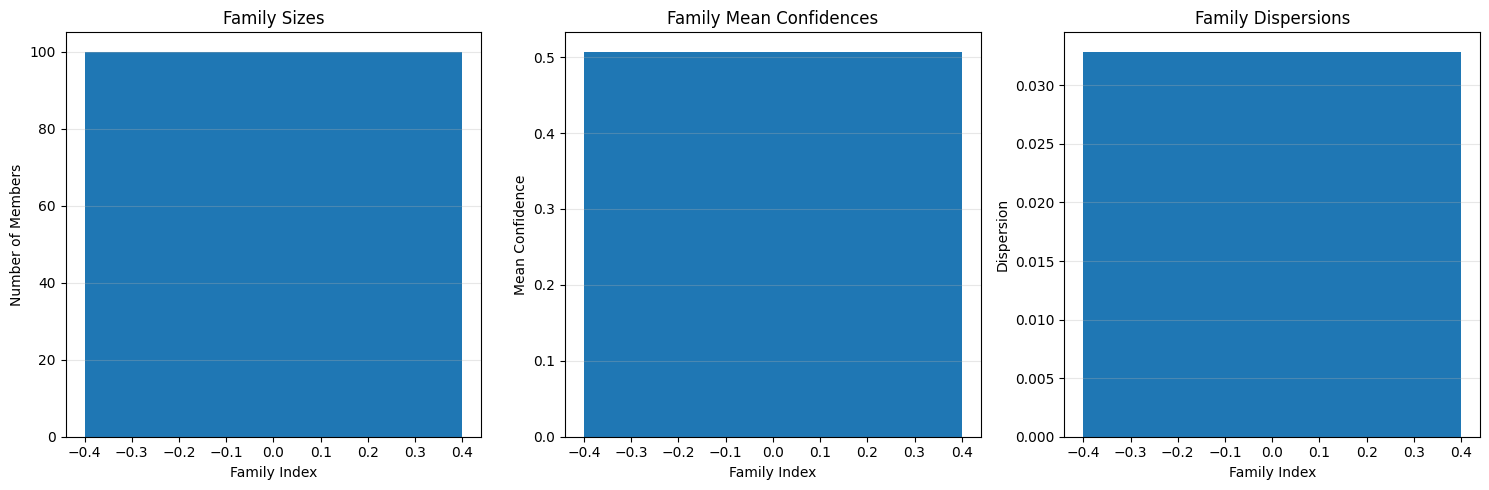


✅ FAMILY FORMATION ALGORITHM COMPLETE

Key Points:
  • Families grouped by regime tuple (exact match)
  • One family per unique regime combination
  • Members sorted by confidence (descending)
  • Coherence computed from confidence distribution
  • Uncertainty flags based on size, dispersion, and phase boundary


In [12]:
# Setup
gen = SyntheticDataGenerator(seed=42)
data = gen.generate_scenario_a(n_historical=100, regime_id='R1')
engine = HPVDEngine(HPVDConfig(default_k=25))
engine.build_from_bundles(data['historical'])

query_bundle = data['query'][0]
query_traj = engine._bundle_to_trajectory(query_bundle)

# Get admitted candidates
candidate_ids = engine.sparse_index.combined_filter(
    trend=query_traj.trend_regime,
    volatility=query_traj.volatility_regime,
    structural=query_traj.structural_regime,
    allow_adjacent=True
)
dense_results = engine.dense_index.search_with_filter(
    query_traj.embedding, candidate_ids, k=100
)

query_regime = query_traj.get_regime_tuple()
evaluated_candidates = []

for tid, faiss_dist in dense_results:
    traj = engine.trajectories.get(tid)
    if traj is None:
        continue
    
    hybrid_dist, components = engine.distance_calc.compute(
        query_traj.matrix, traj.matrix,
        query_regime, traj.get_regime_tuple()
    )
    confidence = max(0.0, 1.0 - min(hybrid_dist, 1.0))
    
    evaluated_candidates.append({
        'trajectory_id': tid,
        'trajectory': traj,
        'confidence': confidence,
        'hybrid_distance': hybrid_dist,
        'regime_match': components['regime_match'],
        'distance_components': components,
        'regime_tuple': traj.get_regime_tuple()
    })

admission_threshold = 0.3
admitted = [c for c in evaluated_candidates if c['confidence'] >= admission_threshold]

print("="*70)
print("FAMILY FORMATION ALGORITHM - DETAILED TRACE")
print("="*70)

print(f"\n📊 Input:")
print(f"  Admitted candidates: {len(admitted)}")
print(f"  Query regime: {query_regime}")

# Step 1: Group by regime tuple
print("\n" + "="*70)
print("STEP 1: Group by Regime Tuple")
print("="*70)

regime_groups = {}
for candidate in admitted:
    regime = candidate['regime_tuple']
    if regime not in regime_groups:
        regime_groups[regime] = []
    regime_groups[regime].append(candidate)

print(f"  Unique regimes found: {len(regime_groups)}")
for regime, members in regime_groups.items():
    print(f"    {regime}: {len(members)} members")

# Step 2: Form families
print("\n" + "="*70)
print("STEP 2: Form Families (One per Regime Group)")
print("="*70)

families = []
family_counter = 0

for regime, members in regime_groups.items():
    if not members:
        continue
    
    family_counter += 1
    family_id = f"AF_{family_counter:03d}"
    
    # Sort by confidence (descending)
    members_sorted = sorted(members, key=lambda x: x['confidence'], reverse=True)
    
    # Create family members
    family_members = [
        {'trajectory_id': m['trajectory_id'], 'confidence': m['confidence']}
        for m in members_sorted
    ]
    
    # Compute coherence
    confidences = [m['confidence'] for m in members_sorted]
    mean_conf = float(np.mean(confidences))
    dispersion = float(np.std(confidences)) if len(confidences) > 1 else 0.0
    
    # Determine phase name
    trend, vol, struct = regime
    if trend == 1 and vol == 0 and struct == 1:
        phase_name = "stable_expansion"
    elif trend == -1 and vol == 0 and struct == -1:
        phase_name = "stable_contraction"
    elif vol == 1 or struct == 1:
        phase_name = "compression_transition"
    elif trend == 0 or vol == 0 or struct == 0:
        phase_name = "transitional"
    else:
        phase_name = "mixed_regime"
    
    # Check phase boundary
    is_phase_boundary = any(abs(c - q) > 1 for c, q in zip(regime, query_regime))
    
    # Check weak support
    weak_support = len(family_members) < 5 or dispersion > 0.3
    
    print(f"\n  Family {family_id}:")
    print(f"    Regime: {regime}")
    print(f"    Phase: {phase_name}")
    print(f"    Members: {len(family_members)}")
    print(f"    Mean confidence: {mean_conf:.4f}")
    print(f"    Dispersion: {dispersion:.4f}")
    print(f"    Uncertainty flags:")
    print(f"      phase_boundary: {is_phase_boundary}")
    print(f"      weak_support: {weak_support}")
    print(f"    Top 3 members:")
    for i, m in enumerate(family_members[:3], 1):
        print(f"      {i}. {m['trajectory_id']}: confidence={m['confidence']:.4f}")
    
    families.append({
        'family_id': family_id,
        'regime': regime,
        'phase': phase_name,
        'members': family_members,
        'coherence': {'mean': mean_conf, 'dispersion': dispersion, 'size': len(family_members)},
        'uncertainty': {'phase_boundary': is_phase_boundary, 'weak_support': weak_support}
    })

print("\n" + "="*70)
print("FAMILY FORMATION SUMMARY")
print("="*70)
print(f"  Total families formed: {len(families)}")
print(f"  Total members across all families: {sum(f['coherence']['size'] for f in families)}")

# Visualize family structure
if len(families) > 0:
    family_sizes = [f['coherence']['size'] for f in families]
    family_confidences = [f['coherence']['mean'] for f in families]
    family_dispersions = [f['coherence']['dispersion'] for f in families]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.bar(range(len(family_sizes)), family_sizes)
    plt.xlabel('Family Index')
    plt.ylabel('Number of Members')
    plt.title('Family Sizes')
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.subplot(1, 3, 2)
    plt.bar(range(len(family_confidences)), family_confidences)
    plt.xlabel('Family Index')
    plt.ylabel('Mean Confidence')
    plt.title('Family Mean Confidences')
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.subplot(1, 3, 3)
    plt.bar(range(len(family_dispersions)), family_dispersions)
    plt.xlabel('Family Index')
    plt.ylabel('Dispersion')
    plt.title('Family Dispersions')
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("✅ FAMILY FORMATION ALGORITHM COMPLETE")
print("="*70)
print("\nKey Points:")
print("  • Families grouped by regime tuple (exact match)")
print("  • One family per unique regime combination")
print("  • Members sorted by confidence (descending)")
print("  • Coherence computed from confidence distribution")
print("  • Uncertainty flags based on size, dispersion, and phase boundary")

In [13]:
print("="*70)
print("END-TO-END EXAMPLE")
print("="*70)

# 1. Generate data
print("\n1️⃣ Generating synthetic data...")
gen = SyntheticDataGenerator(seed=42)
data = gen.generate_scenario_a(n_historical=100, regime_id='R1')
print(f"   ✓ Generated {len(data['historical'])} historical trajectories")
print(f"   ✓ Generated {len(data['query'])} query trajectory")

# 2. Create engine
print("\n2️⃣ Creating HPVD engine...")
config = HPVDConfig(default_k=25, enable_sparse_filter=True, enable_reranking=True)
engine = HPVDEngine(config)
print("   ✓ Engine created")

# 3. Build index
print("\n3️⃣ Building indexes...")
import time
start = time.time()
engine.build_from_bundles(data['historical'])
build_time = time.time() - start
print(f"   ✓ Build complete in {build_time:.3f}s")

# 4. Query
print("\n4️⃣ Running search...")
query = data['query'][0]
start = time.time()
output = engine.search_families(query)
search_time = time.time() - start
print(f"   ✓ Search complete in {search_time*1000:.2f}ms")

# 5. Results
print("\n5️⃣ Results:")
print(f"   ✓ Found {len(output.analog_families)} analog families")
print(f"   ✓ Total members: {sum(f.coherence.size for f in output.analog_families)}")
if len(output.analog_families) > 0:
    print(f"   ✓ Average confidence: {np.mean([f.coherence.mean_confidence for f in output.analog_families]):.4f}")

print("\n" + "="*70)
print("✅ END-TO-END EXAMPLE COMPLETE")
print("="*70)

END-TO-END EXAMPLE

1️⃣ Generating synthetic data...
   ✓ Generated 100 historical trajectories
   ✓ Generated 1 query trajectory

2️⃣ Creating HPVD engine...
   ✓ Engine created

3️⃣ Building indexes...
Building HPVD with 100 trajectories...
Built flat_ip index: 100 vectors, 256 dims
HPVD built in 0.00s
  Sparse index: 1 regimes
  Dense index: 100 vectors
   ✓ Build complete in 0.001s

4️⃣ Running search...
   ✓ Search complete in 3.00ms

5️⃣ Results:
   ✓ Found 1 analog families
   ✓ Total members: 100
   ✓ Average confidence: 0.5074

✅ END-TO-END EXAMPLE COMPLETE


## 15. JSON Structure & Storage

HPVD output dapat disimpan dalam format JSON untuk:
- **Integrasi dengan PMR-DB**: Format standar untuk passing data ke komponen lain
- **Audit & Logging**: Menyimpan hasil query untuk reproducibility
- **Analytics**: Analisis performa dan debugging

### 15.1 Struktur JSON Output HPVD

HPVD_Output memiliki struktur berikut:
- `analog_families`: List keluarga analog dengan members, coherence, structural signature
- `retrieval_diagnostics`: Statistik proses retrieval (candidates, latency, dll)
- `metadata`: Informasi query (query_id, timestamp, schema_version)

In [ ]:
# 15.2 Konversi HPVD_Output ke JSON
import json
from dataclasses import asdict

# Jalankan search untuk mendapatkan output
print("🔍 Running search untuk contoh JSON...")
output = engine.search_families(query_bundle, max_candidates=50)

# Konversi HPVD_Output ke dictionary menggunakan asdict
output_dict = asdict(output)

# Tampilkan struktur JSON (preview)
print("\n📋 Struktur HPVD_Output (JSON):")
print(f"  • analog_families: {len(output_dict['analog_families'])} families")
print(f"  • retrieval_diagnostics: {list(output_dict['retrieval_diagnostics'].keys())}")
print(f"  • metadata: {list(output_dict['metadata'].keys())}")

# Tampilkan contoh struktur family pertama
if len(output_dict['analog_families']) > 0:
    first_family = output_dict['analog_families'][0]
    print(f"\n📊 Contoh Family Structure:")
    print(f"  • family_id: {first_family['family_id']}")
    print(f"  • members: {len(first_family['members'])} members")
    print(f"  • coherence: mean={first_family['coherence']['mean_confidence']:.4f}, "
          f"size={first_family['coherence']['size']}")
    print(f"  • phase: {first_family['structural_signature']['phase']}")
    print(f"  • uncertainty_flags: {first_family['uncertainty_flags']}")

🔍 Running search untuk contoh JSON...

📋 Struktur HPVD_Output (JSON):
  • analog_families: 1 families
  • retrieval_diagnostics: ['candidates_considered', 'candidates_retrieved', 'candidates_admitted', 'candidates_rejected', 'families_formed', 'latency_ms']
  • metadata: ['hpvd_version', 'query_id', 'schema_version', 'timestamp']

📊 Contoh Family Structure:
  • family_id: AF_001
  • members: 50 members
  • coherence: mean=0.5256, size=50
  • phase: stable_expansion
  • uncertainty_flags: {'phase_boundary': False, 'weak_support': False, 'partial_overlap': False}


In [15]:
# 15.3 Menyimpan HPVD_Output ke File JSON
from pathlib import Path
import os

# Buat direktori untuk output
output_dir = Path("hpvd_outputs")
output_dir.mkdir(exist_ok=True)

# Simpan HPVD_Output lengkap
output_file = output_dir / "hpvd_output.json"
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(output_dict, f, indent=2, default=str)

print(f"✅ HPVD_Output saved to: {output_file}")
print(f"   File size: {output_file.stat().st_size / 1024:.2f} KB")

# Tampilkan preview isi file
print(f"\n📄 Preview JSON file (first 500 chars):")
with open(output_file, 'r', encoding='utf-8') as f:
    content = f.read()
    print(content[:500] + "...")

✅ HPVD_Output saved to: hpvd_outputs\hpvd_output.json
   File size: 6.69 KB

📄 Preview JSON file (first 500 chars):
{
  "analog_families": [
    {
      "family_id": "AF_001",
      "members": [
        {
          "trajectory_id": "scenario_A_hist_034",
          "confidence": 0.5688598170591297
        },
        {
          "trajectory_id": "scenario_A_hist_071",
          "confidence": 0.5609600847998841
        },
        {
          "trajectory_id": "scenario_A_hist_049",
          "confidence": 0.555693818176943
        },
        {
          "trajectory_id": "scenario_A_hist_056",
          "confidenc...


### 15.4 Format JSON untuk PMR-DB Integration

PMR-DB diasumsikan membutuhkan format khusus dengan analogs yang sudah di-flatten (bukan families). 
Kita perlu mengkonversi HPVD_Output ke format PMR-DB.

In [16]:
# 15.5 Konversi ke Format PMR-DB
def hpvd_output_to_pmr_format(output: HPVD_Output, trajectory_store: Dict[str, Trajectory]) -> Dict:
    """
    Konversi HPVD_Output ke format yang dibutuhkan PMR-DB.
    
    PMR-DB membutuhkan:
    - List analogs dengan distance, label_h1, label_h5, return_h1, return_h5
    - Metadata query
    - Diagnostics untuk audit
    """
    
    # Flatten families menjadi individual analogs
    analogs = []
    for family in output.analog_families:
        for member in family.members:
            # Ambil trajectory lengkap dari store
            traj = trajectory_store.get(member.trajectory_id)
            if traj:
                analogs.append({
                    'trajectory_id': member.trajectory_id,
                    'asset_id': traj.asset_id,
                    'distance': 1.0 - member.confidence,  # Convert confidence to distance
                    'confidence': member.confidence,
                    'label_h1': traj.label_h1,
                    'label_h5': traj.label_h5,
                    'return_h1': float(traj.return_h1),
                    'return_h5': float(traj.return_h5),
                    'regime_match': 1.0,  # Simplified - bisa dihitung dari regime similarity
                    'family_id': family.family_id,
                    'end_timestamp': traj.end_timestamp.isoformat() if hasattr(traj.end_timestamp, 'isoformat') else str(traj.end_timestamp)
                })
    
    # Struktur output untuk PMR-DB
    pmr_input = {
        'query_metadata': output.metadata,
        'analogs': analogs,
        'diagnostics': output.retrieval_diagnostics,
        'families_summary': [
            {
                'family_id': f.family_id,
                'size': f.coherence.size,
                'mean_confidence': f.coherence.mean_confidence,
                'dispersion': f.coherence.dispersion,
                'phase': f.structural_signature.phase,
                'uncertainty_flags': {
                    'phase_boundary': f.uncertainty_flags.phase_boundary,
                    'weak_support': f.uncertainty_flags.weak_support,
                    'partial_overlap': f.uncertainty_flags.partial_overlap
                }
            }
            for f in output.analog_families
        ]
    }
    
    return pmr_input

# Buat trajectory store dari data yang sudah di-build
# engine.trajectories sudah dalam format Dict[str, Trajectory], jadi langsung copy
trajectory_store = engine.trajectories.copy()

# Konversi ke format PMR-DB
pmr_data = hpvd_output_to_pmr_format(output, trajectory_store)

print("📋 Format PMR-DB:")
print(f"  • Query metadata: {list(pmr_data['query_metadata'].keys())}")
print(f"  • Total analogs: {len(pmr_data['analogs'])}")
print(f"  • Families summary: {len(pmr_data['families_summary'])}")
print(f"  • Diagnostics: {list(pmr_data['diagnostics'].keys())}")

# Tampilkan contoh analog
if len(pmr_data['analogs']) > 0:
    print(f"\n📊 Contoh Analog (untuk PMR-DB):")
    example_analog = pmr_data['analogs'][0]
    for key, value in example_analog.items():
        print(f"  • {key}: {value}")

📋 Format PMR-DB:
  • Query metadata: ['hpvd_version', 'query_id', 'schema_version', 'timestamp']
  • Total analogs: 50
  • Families summary: 1
  • Diagnostics: ['candidates_considered', 'candidates_retrieved', 'candidates_admitted', 'candidates_rejected', 'families_formed', 'latency_ms']

📊 Contoh Analog (untuk PMR-DB):
  • trajectory_id: scenario_A_hist_034
  • asset_id: synthetic
  • distance: 0.4311401829408703
  • confidence: 0.5688598170591297
  • label_h1: 0
  • label_h5: 0
  • return_h1: 0.0
  • return_h5: 0.0
  • regime_match: 1.0
  • family_id: AF_001
  • end_timestamp: 2020-02-04T00:00:00+00:00


In [17]:
# 15.6 Menyimpan Format PMR-DB ke File JSON
pmr_file = output_dir / "pmr_input.json"
with open(pmr_file, 'w', encoding='utf-8') as f:
    json.dump(pmr_data, f, indent=2, default=str)

print(f"✅ PMR-DB input format saved to: {pmr_file}")
print(f"   File size: {pmr_file.stat().st_size / 1024:.2f} KB")

# Bandingkan kedua format
print(f"\n📊 Comparison:")
print(f"  • HPVD_Output: {len(output_dict['analog_families'])} families, "
      f"{sum(len(f['members']) for f in output_dict['analog_families'])} total members")
print(f"  • PMR-DB Format: {len(pmr_data['analogs'])} flattened analogs")

# Tampilkan struktur JSON yang disimpan
print(f"\n📄 PMR-DB JSON Structure:")
print(json.dumps({
    'query_metadata': pmr_data['query_metadata'],
    'analogs_count': len(pmr_data['analogs']),
    'families_summary_count': len(pmr_data['families_summary']),
    'diagnostics': pmr_data['diagnostics']
}, indent=2, default=str))

✅ PMR-DB input format saved to: hpvd_outputs\pmr_input.json
   File size: 19.24 KB

📊 Comparison:
  • HPVD_Output: 1 families, 50 total members
  • PMR-DB Format: 50 flattened analogs

📄 PMR-DB JSON Structure:
{
  "query_metadata": {
    "hpvd_version": "v1",
    "query_id": "scenario_A_query_001",
    "schema_version": "hpvd_output_v1",
    "timestamp": "2022-09-27T00:00:00+00:00"
  },
  "analogs_count": 50,
  "families_summary_count": 1,
  "diagnostics": {
    "candidates_considered": 100,
    "candidates_retrieved": 50,
    "candidates_admitted": 50,
    "candidates_rejected": 0,
    "families_formed": 1,
    "latency_ms": 2.9997825622558594
  }
}


### 15.7 Menyimpan Synthetic Data

Synthetic data dari `SyntheticDataGenerator` juga bisa disimpan untuk:
- **Reproducibility**: Menjalankan ulang eksperimen dengan data yang sama
- **Backup**: Menyimpan dataset untuk referensi masa depan

Karena `HPVDInputBundle` berisi numpy arrays, kita perlu menyimpan dengan format yang tepat.

In [18]:
# 15.8 Fungsi untuk Menyimpan Synthetic Data
import pickle
from pathlib import Path

def save_synthetic_data(data: Dict[str, List[HPVDInputBundle]], 
                        output_dir: Path,
                        scenario_name: str = "scenario_A"):
    """
    Menyimpan synthetic data ke file.
    
    Format:
    - metadata.json: Metadata semua bundles
    - trajectories/: Directory berisi .npy files untuk setiap trajectory
    - dna/: Directory berisi .npy files untuk setiap DNA vector
    - bundles.pkl: Pickle file untuk load cepat (optional)
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Directories
    traj_dir = output_dir / "trajectories"
    dna_dir = output_dir / "dna"
    traj_dir.mkdir(exist_ok=True)
    dna_dir.mkdir(exist_ok=True)
    
    # Metadata untuk semua bundles
    metadata_list = []
    
    # Simpan historical bundles
    for i, bundle in enumerate(data.get('historical', [])):
        bundle_id = bundle.metadata.get('trajectory_id', f'hist_{i:03d}')
        
        # Save trajectory matrix
        traj_file = traj_dir / f"{bundle_id}.npy"
        np.save(traj_file, bundle.trajectory)
        
        # Save DNA vector
        dna_file = dna_dir / f"{bundle_id}.npy"
        np.save(dna_file, bundle.dna)
        
        # Collect metadata
        metadata_list.append({
            'bundle_id': bundle_id,
            'type': 'historical',
            'trajectory_file': str(traj_file.relative_to(output_dir)),
            'dna_file': str(dna_file.relative_to(output_dir)),
            'geometry_context': bundle.geometry_context,
            'metadata': bundle.metadata
        })
    
    # Simpan query bundles
    for i, bundle in enumerate(data.get('query', [])):
        bundle_id = bundle.metadata.get('trajectory_id', f'query_{i:03d}')
        
        # Save trajectory matrix
        traj_file = traj_dir / f"{bundle_id}.npy"
        np.save(traj_file, bundle.trajectory)
        
        # Save DNA vector
        dna_file = dna_dir / f"{bundle_id}.npy"
        np.save(dna_file, bundle.dna)
        
        # Collect metadata
        metadata_list.append({
            'bundle_id': bundle_id,
            'type': 'query',
            'trajectory_file': str(traj_file.relative_to(output_dir)),
            'dna_file': str(dna_file.relative_to(output_dir)),
            'geometry_context': bundle.geometry_context,
            'metadata': bundle.metadata
        })
    
    # Save metadata JSON
    metadata_file = output_dir / "metadata.json"
    with open(metadata_file, 'w', encoding='utf-8') as f:
        json.dump({
            'scenario_name': scenario_name,
            'total_bundles': len(metadata_list),
            'historical_count': len(data.get('historical', [])),
            'query_count': len(data.get('query', [])),
            'bundles': metadata_list
        }, f, indent=2, default=str)
    
    # Optional: Save as pickle untuk load cepat
    pickle_file = output_dir / "bundles.pkl"
    with open(pickle_file, 'wb') as f:
        pickle.dump(data, f)
    
    print(f"✅ Synthetic data saved to: {output_dir}")
    print(f"   • Metadata: {metadata_file}")
    print(f"   • Trajectories: {len(metadata_list)} files in {traj_dir}")
    print(f"   • DNA vectors: {len(metadata_list)} files in {dna_dir}")
    print(f"   • Pickle file: {pickle_file}")
    
    return output_dir

# Contoh: Generate dan simpan synthetic data
print("🔧 Generating synthetic data untuk contoh...")
gen = SyntheticDataGenerator(seed=42)
synthetic_data = gen.generate_scenario_a(n_historical=20, n_query=1)

# Simpan ke file
synthetic_output_dir = Path("synthetic_data") / "scenario_A"
save_synthetic_data(synthetic_data, synthetic_output_dir, scenario_name="scenario_A")

🔧 Generating synthetic data untuk contoh...
✅ Synthetic data saved to: synthetic_data\scenario_A
   • Metadata: synthetic_data\scenario_A\metadata.json
   • Trajectories: 21 files in synthetic_data\scenario_A\trajectories
   • DNA vectors: 21 files in synthetic_data\scenario_A\dna
   • Pickle file: synthetic_data\scenario_A\bundles.pkl


WindowsPath('synthetic_data/scenario_A')

In [19]:
# 15.9 Fungsi untuk Load Synthetic Data
def load_synthetic_data(data_dir: Path, use_pickle: bool = True) -> Dict[str, List[HPVDInputBundle]]:
    """
    Load synthetic data dari file.
    
    Args:
        data_dir: Directory tempat data disimpan
        use_pickle: Jika True, load dari pickle file (lebih cepat)
                    Jika False, load dari individual files
    """
    data_dir = Path(data_dir)
    
    if use_pickle:
        # Load dari pickle (lebih cepat)
        pickle_file = data_dir / "bundles.pkl"
        if pickle_file.exists():
            with open(pickle_file, 'rb') as f:
                data = pickle.load(f)
            print(f"✅ Loaded from pickle: {len(data.get('historical', []))} historical, "
                  f"{len(data.get('query', []))} query bundles")
            return data
    
    # Load dari individual files
    metadata_file = data_dir / "metadata.json"
    with open(metadata_file, 'r', encoding='utf-8') as f:
        metadata = json.load(f)
    
    bundles_historical = []
    bundles_query = []
    
    for bundle_info in metadata['bundles']:
        # Load trajectory
        traj_file = data_dir / bundle_info['trajectory_file']
        trajectory = np.load(traj_file)
        
        # Load DNA
        dna_file = data_dir / bundle_info['dna_file']
        dna = np.load(dna_file)
        
        # Reconstruct bundle
        bundle = HPVDInputBundle(
            trajectory=trajectory,
            dna=dna,
            geometry_context=bundle_info['geometry_context'],
            metadata=bundle_info['metadata']
        )
        
        if bundle_info['type'] == 'historical':
            bundles_historical.append(bundle)
        else:
            bundles_query.append(bundle)
    
    data = {
        'historical': bundles_historical,
        'query': bundles_query
    }
    
    print(f"✅ Loaded from files: {len(bundles_historical)} historical, "
          f"{len(bundles_query)} query bundles")
    
    return data

# Contoh: Load data yang baru saja disimpan
print("\n📂 Loading synthetic data...")
loaded_data = load_synthetic_data(synthetic_output_dir, use_pickle=True)

# Verifikasi
print(f"\n✅ Verification:")
print(f"   • Historical bundles: {len(loaded_data['historical'])}")
print(f"   • Query bundles: {len(loaded_data['query'])}")
print(f"   • First bundle ID: {loaded_data['historical'][0].metadata.get('trajectory_id')}")
print(f"   • Trajectory shape: {loaded_data['historical'][0].trajectory.shape}")
print(f"   • DNA shape: {loaded_data['historical'][0].dna.shape}")


📂 Loading synthetic data...
✅ Loaded from pickle: 20 historical, 1 query bundles

✅ Verification:
   • Historical bundles: 20
   • Query bundles: 1
   • First bundle ID: scenario_A_hist_000
   • Trajectory shape: (60, 45)
   • DNA shape: (16,)


### 15.10 Format Penyimpanan Synthetic Data

**Struktur Directory:**
```
synthetic_data/
└── scenario_A/
    ├── metadata.json          # Metadata semua bundles (JSON)
    ├── bundles.pkl            # Pickle file untuk load cepat (optional)
    ├── trajectories/          # Trajectory matrices (.npy files)
    │   ├── scenario_A_hist_000.npy
    │   ├── scenario_A_hist_001.npy
    │   └── ...
    └── dna/                   # DNA vectors (.npy files)
        ├── scenario_A_hist_000.npy
        ├── scenario_A_hist_001.npy
        └── ...
```

**Keuntungan format ini:**
- **NPY files**: Efficient untuk numpy arrays, bisa di-load cepat
- **JSON metadata**: Human-readable, mudah di-inspect
- **Pickle file**: Option untuk load cepat semua bundles sekaligus
- **Modular**: Bisa load individual bundles jika diperlukan

**Kapan menggunakan:**
- **NPY + JSON**: Untuk sharing, version control (NPY files bisa di-gitignore)
- **Pickle**: Untuk internal use, development, testing (lebih cepat)

### 15.11 Ringkasan Format JSON

**HPVD_Output Format** (untuk internal HPVD):
- Struktur berbasis families (grouped analogs)
- Cocok untuk analisis struktur dan coherence
- Menggunakan `asdict()` untuk konversi

**PMR-DB Format** (untuk integrasi):
- Struktur flattened (individual analogs)
- Setiap analog memiliki semua field yang dibutuhkan PMR-DB
- Termasuk outcomes (label_h1, label_h5, return_h1, return_h5)
- Metadata dan diagnostics untuk audit

**Kapan menggunakan masing-masing format:**
- **HPVD_Output**: Untuk analisis internal, debugging, memahami struktur families
- **PMR-DB Format**: Untuk passing ke PMR-DB, API responses, database storage

## 15. Summary & Key Takeaways

### Key Functions & Their Roles:

1. **SyntheticDataGenerator**: Membuat test data dengan berbagai scenarios
2. **SparseRegimeIndex**: Fast filtering berdasarkan regime (O(1) lookup)
3. **DenseTrajectoryIndex**: FAISS-based vector similarity search
4. **HybridDistanceCalculator**: Multi-component distance computation
5. **HPVDEngine**: Main orchestrator yang menggabungkan semua komponen

### Search Flow (Simplified):

```
Query → Sparse Filter → Dense Search → Intersection → Rerank → Group Families → Output
```

### Search Flow (7 Stages Detail):

```
1. Evolutionary Compatibility Screening (Sparse Filter + Fallback)
   ↓
2. Candidate Retrieval (Dense Search with Filter)
   ↓
3. Multi-Channel Similarity Evaluation (Hybrid Distance + Confidence)
   ↓
4. Probabilistic Neighborhood Admission (Threshold-based)
   ↓
5. Analog Family Formation (Group by Regime)
   ↓
6. Uncertainty Annotation (Flags computation)
   ↓
7. Output Assembly (HPVD_Output with Diagnostics)
```

### Key Design Decisions:

- **Hybrid Approach**: Sparse + Dense untuk best of both worlds
- **Family-Based Output**: Group analogs by structural similarity
- **Outcome-Blind**: HPVD hanya retrieval
- **Regime Filtering**: Fast pre-filtering sebelum expensive search

### Performance Characteristics:

- **Build Time**: < 1s untuk 500 trajectories
- **Query Latency**: < 50ms untuk 500 trajectories
- **Scalability**: FAISS handles millions of vectors

### Key Implementation Details:

- **Admission Threshold**: 0.3 (minimum confidence)
- **Family Formation**: Group by regime tuple, one family per regime
- **Uncertainty Flags**: Based on size (< 5), dispersion (> 0.3), phase boundary
- **Fallback Logic**: Progressive relaxation jika terlalu sedikit candidates

In [20]:
print("✅ Notebook complete!")
print("\nKey takeaways:")
print("  • HPVD uses hybrid search (sparse + dense)")
print("  • Sparse index filters by regime (fast)")
print("  • Dense index finds similar embeddings (accurate)")
print("  • Hybrid distance combines multiple metrics")
print("  • Results grouped into families with coherence metrics")
print("  • 7-stage pipeline dengan fallback logic")
print("  • Admission threshold (0.3) untuk quality control")
print("  • Family formation berdasarkan regime grouping")


✅ Notebook complete!

Key takeaways:
  • HPVD uses hybrid search (sparse + dense)
  • Sparse index filters by regime (fast)
  • Dense index finds similar embeddings (accurate)
  • Hybrid distance combines multiple metrics
  • Results grouped into families with coherence metrics
  • 7-stage pipeline dengan fallback logic
  • Admission threshold (0.3) untuk quality control
  • Family formation berdasarkan regime grouping
